In [13]:
from pandas import read_csv, DataFrame
from numpy import ndarray
from matplotlib.pyplot import figure, show, savefig
from sklearn.model_selection import train_test_split

from dslab_functions import get_variable_types, run_NB, run_KNN, CLASS_EVAL_METRICS, plot_multibar_chart

def evaluate_approach(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    eval_NB: dict[str, float] | None = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] | None = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_NB != {} and eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = [eval_NB[met], eval_KNN[met]]
    return eval

# read file
filename = "class_pos_covid.csv"
file_tag = "class_pos_covid"
data : DataFrame = read_csv('class_pos_covid.csv')
data.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
3,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Male,Poor,1.0,0.0,Within past year (anytime less than 12 months ...,No,7.0,NaN,Yes,...,1.80,84.82,26.08,No,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [14]:
# cleaning
columns = ['ID']
existing_columns = [col for col in columns if col in data.columns]
if len(existing_columns) > 0:
    data.drop(columns = existing_columns, inplace = True)

vars: dict[str, list] = get_variable_types(data)
for v in vars["symbolic"]:
    print(v, data[v].unique())

State ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Guam' 'Puerto Rico'
 'Virgin Islands']
GeneralHealth ['Very good' 'Excellent' 'Fair' 'Poor' 'Good' nan]
LastCheckupTime ['Within past year (anytime less than 12 months ago)' nan
 'Within past 2 years (1 year but less than 2 years ago)'
 'Within past 5 years (2 years but less than 5 years ago)'
 '5 or more years ago']
RemovedTeeth [nan 'None of them' '1 to 5' '6 or more, but not all' 'Al

# VARIABLE ENCODING

- ID: drop
- Binary vars: ole              
- State: oebt			
- GeneralHealth: ole						
- LastCheckUpTime: ole					
- SmokerStatus:	ole					
- ECigaretteUsage: ole					
- RaceEthnicityCategory: ole						
- AgeCategory: ole			
- TetanusLast10Tdap: ole

haddiabetes and removedteeth missing from forms!

### BINARY

In [15]:
# encode binary
yes_no: dict[str, int] = {"no": 0, "No": 0, "yes": 1, "Yes": 1}
fem_male: dict[str, int] = {"female": 0, "Female": 0, "male": 1, "Male": 1}

encoding: dict[str, dict[str, int]] = {
    "CovidPos": yes_no,
    "PhysicalActivities": yes_no,
    "HadHeartAttack": yes_no,
    "HadAngina": yes_no,
    "HadStroke": yes_no,
    "HadAsthma": yes_no,
    "HadSkinCancer": yes_no,
    "HadCOPD": yes_no,
    "HadDepressiveDisorder": yes_no,
    "HadKidneyDisease": yes_no,
    "HadArthritis": yes_no,
    "DeafOrHardOfHearing": yes_no,
    "BlindOrVisionDifficulty": yes_no,
    "DifficultyConcentrating": yes_no,
    "DifficultyWalking": yes_no,
    "DifficultyDressingBathing": yes_no,
    "DifficultyErrands": yes_no,
    "ChestScan": yes_no,
    "AlcoholDrinkers": yes_no,
    "HIVTesting": yes_no,
    "FluVaxLast12": yes_no,
    "PneumoVaxEver": yes_no,
    "HighRiskLastYear": yes_no,
    "Sex": fem_male,
}

### SYMBOLIC

In [16]:
#encode symbolic
state_gdp: dict[str, float] = {
    'Alabama': 54.753,
    'Alaska': 86.722,
    'Arizona': 62.365,
    'Arkansas': 54.259,
    'California': 92.190,
    'Colorado': 82.954,
    'Connecticut': 88.760,
    'Delaware': 85.977,
    'District of Columbia': 242.853,
    'Florida': 62.446,
    'Georgia': 69.253,
    'Hawaii': 68.207,
    'Idaho': 56.496,
    'Illinois': 82.126,
    'Indiana': 66.698,
    'Iowa': 72.221,
    'Kansas': 71.729,
    'Kentucky': 57.653,
    'Louisiana': 61.313,
    'Maine': 61.008,
    'Maryland': 76.279,
    'Massachusetts': 98.609,
    'Michigan': 61.859,
    'Minnesota': 78.100,
    'Mississippi': 47.190,
    'Missouri': 63.126,
    'Montana': 57.945,
    'Nebraska': 82.207,
    'Nevada': 67.962,
    'New Hampshire': 75.565,
    'New Jersey': 80.490,
    'New Mexico': 57.792,
    'New York': 104.344,
    'North Carolina': 68.243,
    'North Dakota': 94.021,
    'Ohio': 69.978,
    'Oklahoma': 59.894,
    'Oregon': 70.548,
    'Pennsylvania': 71.160,
    'Rhode Island': 65.362,
    'South Carolina': 56.066,
    'South Dakota': 74.268,
    'Tennessee': 67.473,
    'Texas': 78.456,
    'Utah': 73.424,
    'Vermont': 62.771,
    'Virginia': 74.789,
    'Washington': 93.193,
    'West Virginia': 53.852,
    'Wisconsin': 68.192,
    'Wyoming': 81.586,
    'Guam': 34.624,
    'Puerto Rico': 31.429,
    'Virgin Islands': 39.552
}
encoding["State"] = state_gdp

def apply_encoding(df: DataFrame):
    df['GeneralHealth'] = df.apply(lambda x: 1 if x["GeneralHealth"] == "Poor"
                               else 2 if x["GeneralHealth"] == "Fair"
                               else 3 if x["GeneralHealth"] == "Good"
                               else 4 if x["GeneralHealth"] == "Very good"
                               else 5 if x["GeneralHealth"] == "Excellent"
                               else None, axis=1)

    df['LastCheckupTime'] = df.apply(lambda x: 4 if x["LastCheckupTime"] == "Within past year (anytime less than 12 months ago)"
                                else 3 if x["LastCheckupTime"] == "Within past 2 years (1 year but less than 2 years ago)"
                                else 2 if x["LastCheckupTime"] == "Within past 5 years (2 years but less than 5 years ago)"
                                else 1 if x["LastCheckupTime"] == "5 or more years ago"
                                else None, axis=1)

    df['RemovedTeeth'] = df.apply(lambda x: 4 if x["RemovedTeeth"] == "None of them"
                                else 3 if x["RemovedTeeth"] == "1 to 5"
                                else 2 if x["RemovedTeeth"] == "6 or more, but not all"
                                else 1 if x["RemovedTeeth"] == "All"
                                else None, axis=1)

    df['HadDiabetes'] = df.apply(lambda x: 4 if x["HadDiabetes"] == "No"
                                else 3 if x["HadDiabetes"] == "No, pre-diabetes or borderline diabetes"
                                else 2 if x["HadDiabetes"] == "Yes, but only during pregnancy (female)"
                                else 1 if x["HadDiabetes"] == "Yes"
                                else None, axis=1)

    df['SmokerStatus'] = df.apply(lambda x: 4 if x["SmokerStatus"] == "Never smoked"
                                else 3 if x["SmokerStatus"] == "Former smoker"
                                else 2 if x["SmokerStatus"] == "Current smoker - now smokes some days"
                                else 1 if x["SmokerStatus"] == "Current smoker - now smokes every day"
                                else None, axis=1)

    df['ECigaretteUsage'] = df.apply(lambda x: 4 if x["ECigaretteUsage"] == "Never used e-cigarettes in my entire life"
                                else 3 if x["ECigaretteUsage"] == "Not at all (right now)"
                                else 2 if x["ECigaretteUsage"] == "Use them some days"
                                else 1 if x["ECigaretteUsage"] == "Use them every day"
                                else None, axis=1)

    df['RaceEthnicityCategory'] = df.apply(lambda x: 0 if x["RaceEthnicityCategory"] == "Hispanic"
                                else 1 if x["RaceEthnicityCategory"] == "White only, Non-Hispanic"
                                else 2 if x["RaceEthnicityCategory"] == "Black only, Non-Hispanic"
                                else 3 if x["RaceEthnicityCategory"] == "Multiracial, Non-Hispanic"
                                else 4 if x["RaceEthnicityCategory"] == "Other race only, Non-Hispanic"
                                else None, axis=1)

    df['AgeCategory'] = df.apply(lambda x: 1 if x["AgeCategory"] == "Age 18 to 24"
                                else 2 if x["AgeCategory"] == "Age 25 to 29"
                                else 3 if x["AgeCategory"] == "Age 30 to 34"
                                else 4 if x["AgeCategory"] == "Age 35 to 39"
                                else 5 if x["AgeCategory"] == "Age 40 to 44"
                                else 6 if x["AgeCategory"] == "Age 45 to 49"
                                else 7 if x["AgeCategory"] == "Age 50 to 54"
                                else 8 if x["AgeCategory"] == "Age 55 to 59"
                                else 9 if x["AgeCategory"] == "Age 60 to 64"
                                else 10 if x["AgeCategory"] == "Age 65 to 69"
                                else 11 if x["AgeCategory"] == "Age 70 to 74"
                                else 12 if x["AgeCategory"] == "Age 75 to 79"
                                else 13 if x["AgeCategory"] == "Age 80 or older"
                                else None, axis=1)
    if 'TetanusLast10Tdap' in df.columns:
        df['TetanusLast10Tdap'] = df.apply(lambda x: 0 if x["TetanusLast10Tdap"] == "No, did not receive any tetanus shot in the past 10 years"
                                else 1 if x["TetanusLast10Tdap"] == "Yes, received tetanus shot but not sure what type"
                                else 2 if x["TetanusLast10Tdap"] == "Yes, received tetanus shot, but not Tdap"
                                else 3 if x["TetanusLast10Tdap"] == "Yes, received Tdap"
                                else None, axis=1)

# MISSING VALUES IMPUTATION

Dataset nr records=380932 nr variables=40


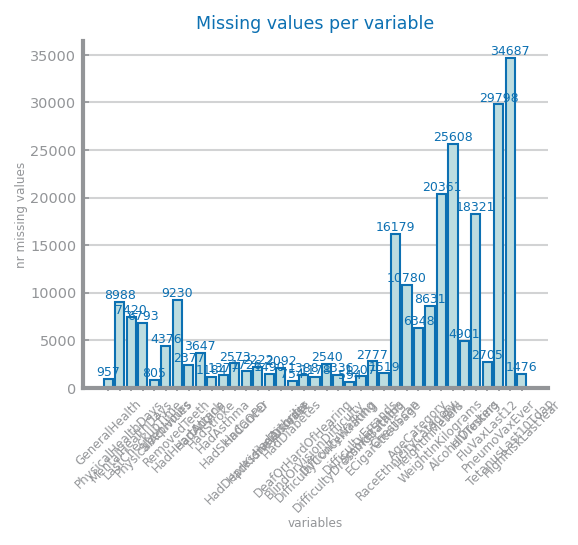

In [17]:
from dslab_functions import mvi_by_dropping, mvi_by_filling
from dslab_functions import plot_bar_chart

print(f"Dataset nr records={data.shape[0]}", f"nr variables={data.shape[1]}")

mv: dict[str, int] = {}
figure()
for var in data:
    nr: int = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr

plot_bar_chart(
    list(mv.keys()),
    list(mv.values()),
    title="Missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
show()

### MVI FIRST APPROACH - dropping variables with >5% mv and records with >30% mv then imputing with median

In [18]:
df: DataFrame = mvi_by_dropping(data, min_pct_per_variable=0.95, min_pct_per_record=0.7)
print(df.shape)

df: DataFrame = mvi_by_filling(df, strategy="frequent")
df.head()

(380721, 36)


,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,State,GeneralHealth,LastCheckupTime,RemovedTeeth,HadDiabetes,SmokerStatus,...,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,ChestScan,AlcoholDrinkers,HIVTesting,FluVaxLast12,HighRiskLastYear,CovidPos
0,0.0,0.0,8.0,1.70,Alabama,Very good,Within past year (anytime less than 12 months ...,None of them,Yes,Never smoked,...,No,No,No,No,No,No,No,Yes,No,No
1,0.0,0.0,6.0,1.60,Alabama,Excellent,Within past year (anytime less than 12 months ...,None of them,No,Never smoked,...,No,No,No,No,No,No,No,No,No,No
2,0.0,0.0,7.0,1.65,Alabama,Excellent,Within past year (anytime less than 12 months ...,None of them,No,Current smoker - now smokes some days,...,No,No,No,No,Yes,No,No,Yes,No,No
3,2.0,0.0,9.0,1.57,Alabama,Fair,Within past year (anytime less than 12 months ...,None of them,No,Never smoked,...,No,No,No,No,Yes,Yes,No,No,No,No
4,1.0,0.0,7.0,1.80,Alabama,Poor,Within past year (anytime less than 12 months ...,None of them,Yes,Never smoked,...,No,No,No,No,No,No,No,No,No,No


In [19]:
# apply encoding
df: DataFrame = df.replace(encoding, inplace=False)
apply_encoding(df)
#df

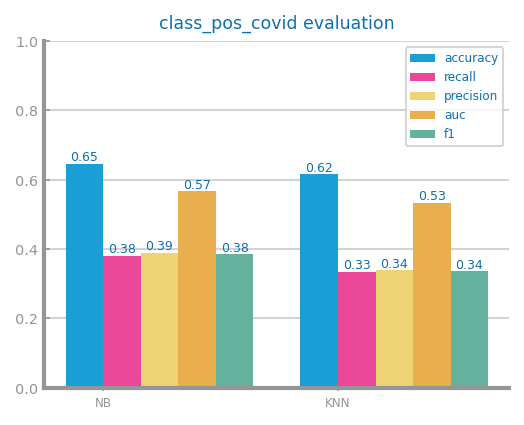

In [20]:
import pandas as pd
target = 'CovidPos'
X, y = df.loc[:, df.columns != 'CovidPos'], df['CovidPos']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

#Xtrain['CovidPos'] = Ytrain
#Xtest['CovidPos'] = Ytest
train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/missing_values/eval_approach1.png")
show()

df.to_csv(f"data/{file_tag}/data_preparation/missing_values/eval_approach1.csv", index=True)

### MVI SECOND APPROACH - dropping variables with >10% mv and records with >90% mv then imputing with median

In [21]:
df: DataFrame = mvi_by_dropping(data, min_pct_per_variable=0.90, min_pct_per_record=0.9)
print(df.shape)

# change to mean
df: DataFrame = mvi_by_filling(df, strategy="frequent")
df.head()

(375892, 40)


,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI,State,GeneralHealth,LastCheckupTime,RemovedTeeth,...,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,ChestScan,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos
0,0.0,0.0,8.0,1.70,81.19,27.44,Alabama,Very good,Within past year (anytime less than 12 months ...,None of them,...,No,No,No,No,No,No,Yes,No,No,No
1,0.0,0.0,6.0,1.60,68.04,26.57,Alabama,Excellent,Within past year (anytime less than 12 months ...,None of them,...,No,No,No,No,No,No,No,No,No,No
2,0.0,0.0,7.0,1.65,63.50,23.30,Alabama,Excellent,Within past year (anytime less than 12 months ...,None of them,...,No,No,No,Yes,No,No,Yes,Yes,No,No
3,2.0,0.0,9.0,1.57,53.98,21.77,Alabama,Fair,Within past year (anytime less than 12 months ...,None of them,...,No,No,No,Yes,Yes,No,No,Yes,No,No
4,1.0,0.0,7.0,1.80,84.82,26.08,Alabama,Poor,Within past year (anytime less than 12 months ...,None of them,...,No,No,No,No,No,No,No,Yes,No,No


In [22]:
# apply encoding
df: DataFrame = df.replace(encoding, inplace=False)
apply_encoding(df)
#df

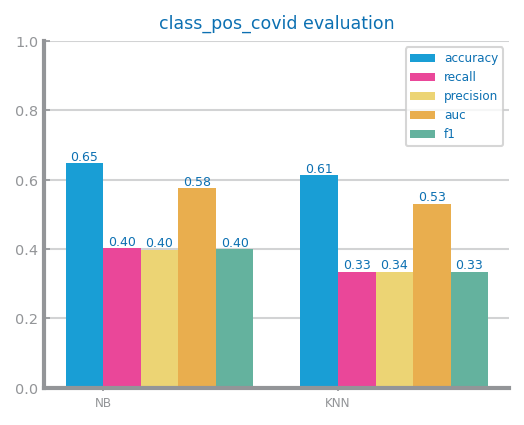

In [23]:
target = 'CovidPos'
X, y = df.loc[:, df.columns != 'CovidPos'], df['CovidPos']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

#Xtrain['CovidPos'] = Ytrain
#Xtest['CovidPos'] = Ytest
train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/missing_values/eval_approach2.png")
show()

df.to_csv(f"data/{file_tag}/data_preparation/missing_values/eval_approach2.csv", index=True)

### DROP OUTLIERS

In [24]:
from pandas import read_csv, DataFrame, Series

from dslab_functions import NR_STDEV, get_variable_types, determine_outlier_thresholds_for_var

file_tag = "class_pos_covid"
data : DataFrame = read_csv('data/class_pos_covid/data_preparation/missing_values/eval_approach2.csv')
print(f"Original data: {data.shape}")

n_std: int = NR_STDEV
numeric_vars: list[str] = get_variable_types(data)["numeric"]
if numeric_vars is not None:
    df: DataFrame = data.copy(deep=True)
    summary5: DataFrame = data[numeric_vars].describe()
    for var in numeric_vars:
        top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
            summary5[var], True, 4
        )
        outliers: Series = df[(df[var] > top_threshold) | (df[var] < bottom_threshold)]
        df.drop(outliers.index, axis=0, inplace=True)
    df.to_csv(f"data/{file_tag}/data_preparation/outliers/drop_outliers.csv", index=True)
    print(f"Data after dropping outliers: {df.shape}")
else:
    print("There are no numeric variables")

df.describe()

Original data: (375892, 41)
Data after dropping outliers: (359550, 41)


,Unnamed: 0,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI,State,GeneralHealth,LastCheckupTime,...,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,ChestScan,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos
count,359550.000000,359550.000000,359550.000000,359550.000000,359550.000000,359550.000000,359550.000000,359550.000000,359550.000000,359550.000000,...,359550.000000,359550.000000,359550.000000,359550.000000,359550.000000,359550.000000,359550.000000,359550.000000,359550.000000,359550.000000
mean,188155.524895,4.206953,4.148188,7.020106,1.702375,82.683376,28.367821,72.863038,3.439811,3.674298,...,0.160998,0.038064,0.074157,0.413511,0.528013,0.317945,0.533650,0.388953,0.039291,0.289545
std,108079.893999,8.584585,8.147329,1.344128,0.104783,19.825387,5.918579,14.432163,1.045174,0.760108,...,0.367530,0.191352,0.262026,0.492464,0.499215,0.465678,0.498867,0.487513,0.194286,0.453552
min,0.000000,0.000000,0.000000,2.000000,1.300000,22.680000,12.020000,31.429000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,95125.250000,0.000000,0.000000,6.000000,1.630000,68.040000,24.370000,62.446000,3.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,188008.500000,0.000000,0.000000,7.000000,1.700000,81.190000,27.440000,71.729000,4.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,281008.750000,3.000000,4.000000,8.000000,1.780000,92.990000,31.320000,81.586000,4.000000,4.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,375891.000000,30.000000,30.000000,12.000000,2.110000,166.920000,54.030000,104.344000,5.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


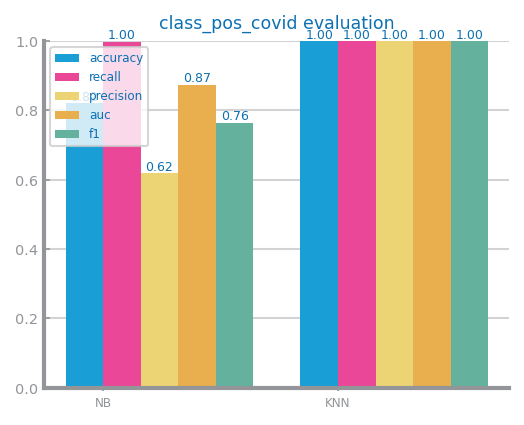

In [25]:
import pandas as pd
target = 'CovidPos'
X, y = df.loc[:, df.columns != 'CovidPos'], df['CovidPos']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

#Xtrain['CovidPos'] = Ytrain
#Xtest['CovidPos'] = Ytest
train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/outliers/drop_outliers_eval_approach1.png")
show()

### REPLACING OUTLIERS WITH FIXED VALUES

In [26]:
file_tag = "class_pos_covid"
data : DataFrame = read_csv('data/class_pos_covid/data_preparation/missing_values/eval_approach2.csv')
print(f"Original data: {data.shape}")

if [] != numeric_vars:
    df: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var],True, 4)
        median: float = df[var].median()
        df[var] = df[var].apply(lambda x: median if x > top or x < bottom else x)
    df.to_csv(f"data/{file_tag}/data_preparation/outliers/replacing_outliers.csv", index=True)
    print("Data after replacing outliers:", df.shape)
    print(df.describe())
else:
    print("There are no numeric variables")

Original data: (375892, 41)
Data after replacing outliers: (375892, 41)
          Unnamed: 0  PhysicalHealthDays  MentalHealthDays     SleepHours  \
count  375892.000000       375892.000000     375892.000000  375892.000000   
mean   187945.500000            4.280418          4.333827       7.007704   
std    108510.818031            8.655276          8.337936       1.348218   
min         0.000000            0.000000          0.000000       2.000000   
25%     93972.750000            0.000000          0.000000       6.000000   
50%    187945.500000            0.000000          0.000000       7.000000   
75%    281918.250000            3.000000          4.000000       8.000000   
max    375891.000000           30.000000         30.000000      12.000000   

       HeightInMeters  WeightInKilograms            BMI          State  \
count   375892.000000      375892.000000  375892.000000  375892.000000   
mean         1.702933          82.794201      28.373696      72.822905   
std         

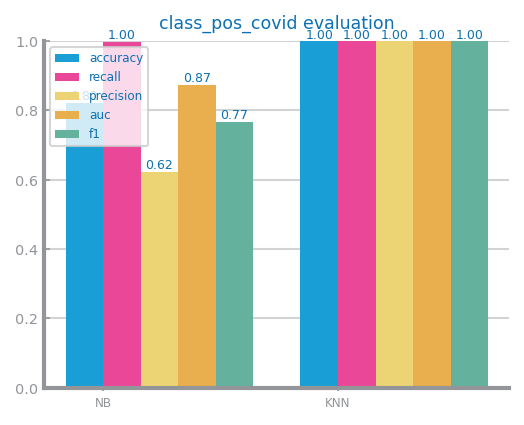

In [27]:
target = 'CovidPos'
X, y = df.loc[:, df.columns != 'CovidPos'], df['CovidPos']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/outliers/replacing_outliers_eval_approach2.png")
show()

### TRUNCATING OUTLIERS

In [28]:
file_tag = "class_pos_covid"
data : DataFrame = read_csv('data/class_pos_covid/data_preparation/missing_values/eval_approach2.csv')
print(f"Original data: {data.shape}")

if [] != numeric_vars:
    df: DataFrame = data.copy(deep=True)
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var], True, 4)
        df[var] = df[var].apply(
            lambda x: top if x > top else bottom if x < bottom else x
        )
    df.to_csv(f"data/{file_tag}/data_preparation/outliers/truncate_outliers.csv", index=True)
    print("Data after truncating outliers:", df.shape)
    print(df.describe())
else:
    print("There are no numeric variables")

Original data: (375892, 41)
Data after truncating outliers: (375892, 41)
          Unnamed: 0  PhysicalHealthDays  MentalHealthDays     SleepHours  \
count  375892.000000       375892.000000     375892.000000  375892.000000   
mean   187945.500000            4.280418          4.333827       7.013206   
std    108510.818031            8.655276          8.337936       1.419870   
min         0.000000            0.000000          0.000000       1.101915   
25%     93972.750000            0.000000          0.000000       6.000000   
50%    187945.500000            0.000000          0.000000       7.000000   
75%    281918.250000            3.000000          4.000000       8.000000   
max    375891.000000           30.000000         30.000000      12.944252   

       HeightInMeters  WeightInKilograms            BMI          State  \
count   375892.000000      375892.000000  375892.000000  375892.000000   
mean         1.702743          83.078137      28.491207      73.402206   
std        

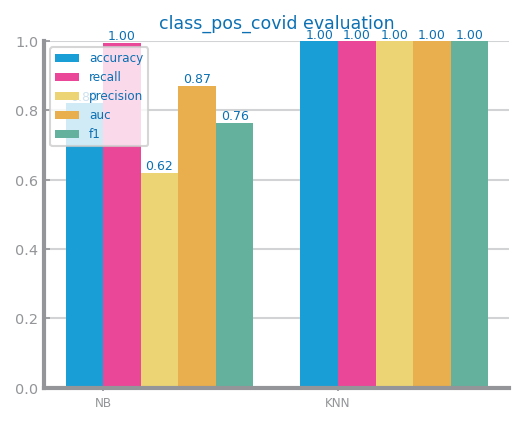

In [29]:
target = 'CovidPos'
X, y = df.loc[:, df.columns != 'CovidPos'], df['CovidPos']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/outliers/truncate_outliers_eval_approach3.png")
show()

# SCALING

### Z-SCORE

In [30]:
from pandas import read_csv, DataFrame, Series
from sklearn.preprocessing import StandardScaler

file = "class_pos_covid"
data : DataFrame = read_csv('data/class_pos_covid/data_preparation/outliers/drop_outliers.csv')

target = "CovidPos"
vars: list[str] = data.columns.to_list()
target_data: Series = data.pop(target)

transf: StandardScaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(data)
df_zscore = DataFrame(transf.transform(data), index=data.index)
df_zscore[target] = target_data
df_zscore.columns = vars
df_zscore.to_csv(f"data/{file}/data_preparation/scaling/zscore.csv", index=True)

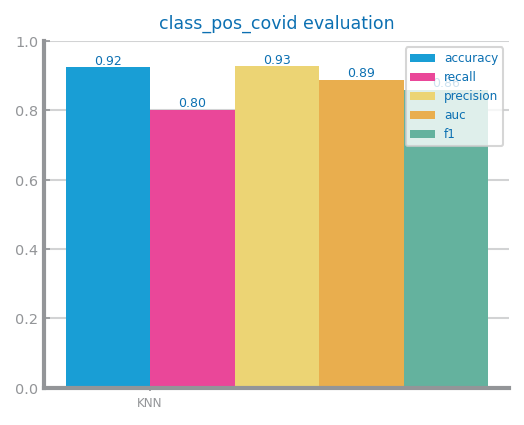

In [31]:
def evaluate_knn(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    #eval_NB: dict[str, float] | None = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] | None = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = eval_KNN[met]
    return eval


target = 'CovidPos'
X, y = df_zscore.loc[:, df_zscore.columns != 'CovidPos'], df_zscore['CovidPos']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)

figure()
eval: dict[str, list] = evaluate_knn(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/scaling/zscore.png")
show()

### MINMAX SCALER

In [32]:
from sklearn.preprocessing import MinMaxScaler

file = "class_pos_covid"
data : DataFrame = read_csv('data/class_pos_covid/data_preparation/outliers/replacing_outliers.csv')

target = "CovidPos"
vars: list[str] = data.columns.to_list()
target_data: Series = data.pop(target)

transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
df_minmax = DataFrame(transf.transform(data), index=data.index)
df_minmax[target] = target_data
df_minmax.columns = vars
df_minmax.to_csv(f"data/{file}/data_preparation/scaling/minmax.csv", index=True)

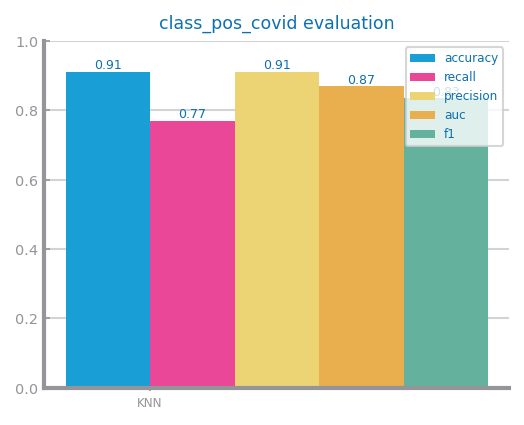

In [33]:
def evaluate_knn(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    #eval_NB: dict[str, float] | None = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] | None = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = eval_KNN[met]
    return eval

target = 'CovidPos'
X, y = df_minmax.loc[:, df_minmax.columns != 'CovidPos'], df_minmax['CovidPos']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)

figure()
eval: dict[str, list] = evaluate_knn(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/scaling/minmax.png")
show()

### NO SCALING

In [34]:
from sklearn.preprocessing import MinMaxScaler
import shutil

file = "class_pos_covid"
source_file = 'data/class_pos_covid/data_preparation/outliers/replacing_outliers.csv'
destination_file = 'data/class_pos_covid/data_preparation/scaling/no_scaling.csv'

shutil.copyfile(source_file, destination_file)

data : DataFrame = read_csv(destination_file)
df = data.copy(deep=True)

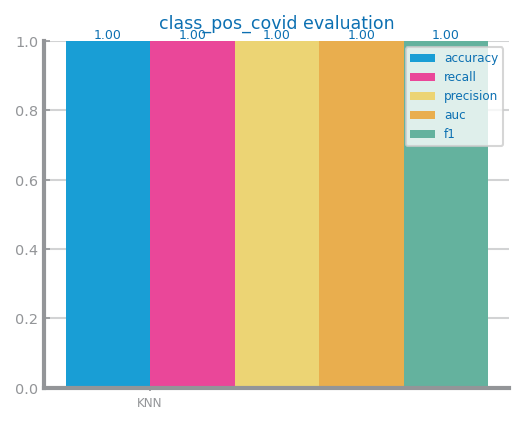

In [35]:
def evaluate_knn(
    train: DataFrame, test: DataFrame, target: str = "class", metric: str = "accuracy"
) -> dict[str, list]:
    trnY = train.pop(target).values
    trnX: ndarray = train.values
    tstY = test.pop(target).values
    tstX: ndarray = test.values
    eval: dict[str, list] = {}

    #eval_NB: dict[str, float] | None = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN: dict[str, float] | None = run_KNN(trnX, trnY, tstX, tstY, metric=metric)
    if eval_KNN != {}:
        for met in CLASS_EVAL_METRICS:
            eval[met] = eval_KNN[met]
    return eval

target = 'CovidPos'
X, y = df.loc[:, df.columns != 'CovidPos'], df['CovidPos']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)

figure()
eval: dict[str, list] = evaluate_knn(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/scaling/no_scaling.png")
show()

### COMPARE ORIGINAL TO ZSCORE AND MINMAX

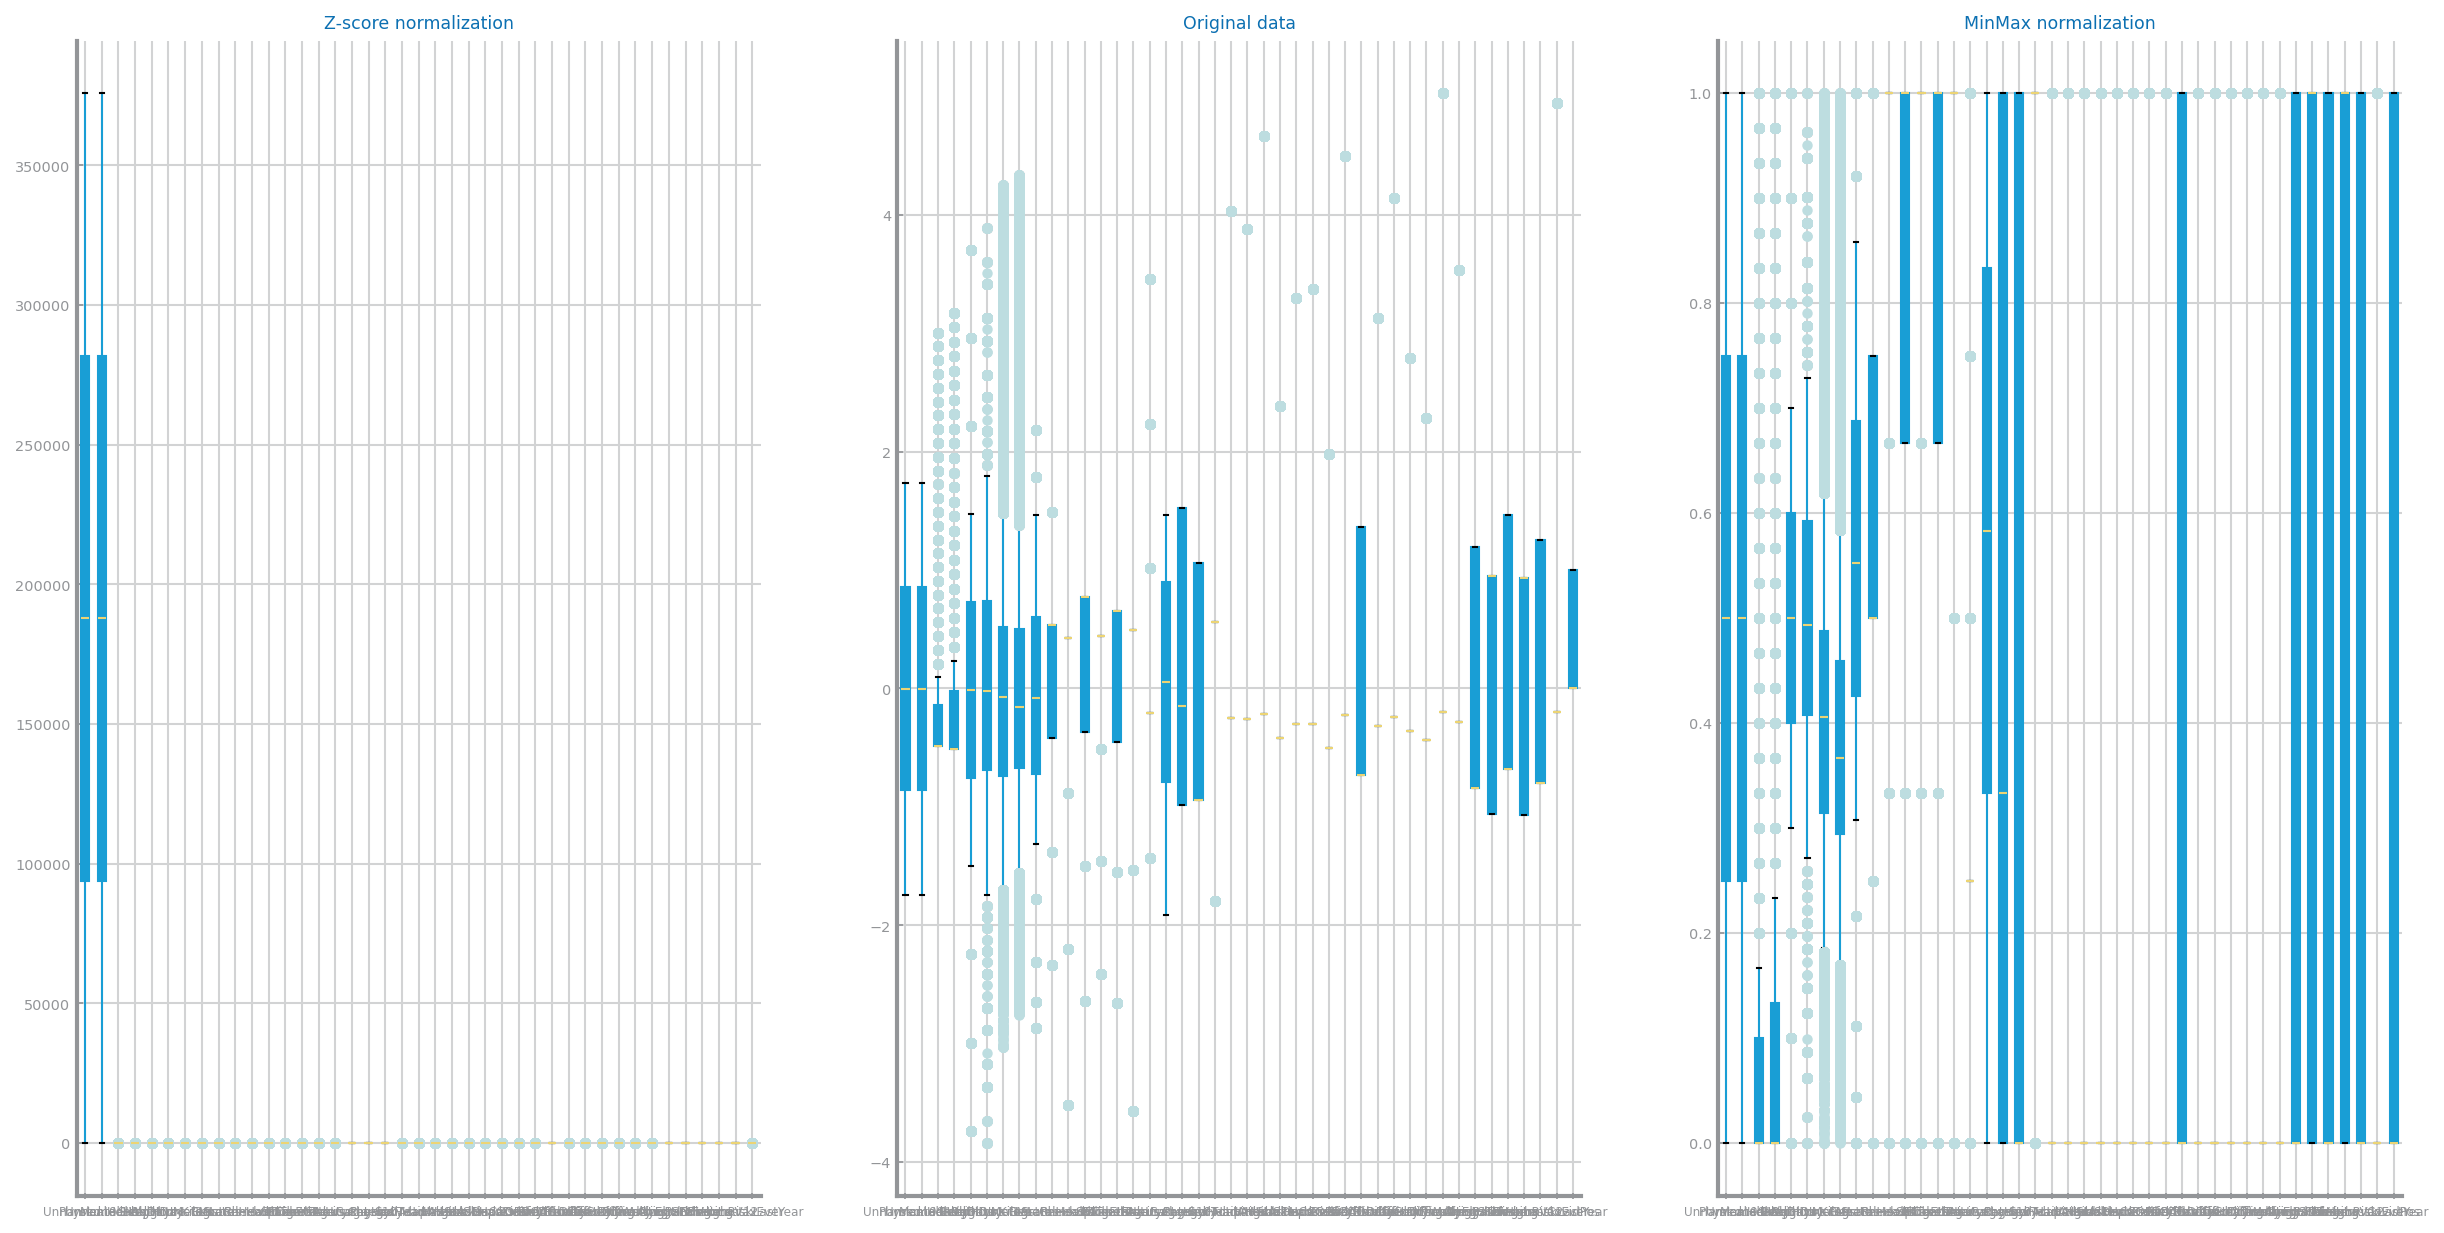

In [36]:
from matplotlib.pyplot import subplots, show

file = "class_pos_covid"
data : DataFrame = read_csv('data/class_pos_covid/data_preparation/outliers/replacing_outliers.csv')

target = "CovidPos"
vars: list[str] = data.columns.to_list()
target_data: Series = data.pop(target)

fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
axs[0, 1].set_title("Original data")
data.boxplot(ax=axs[0, 0])
axs[0, 0].set_title("Z-score normalization")
df_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title("MinMax normalization")
df_minmax.boxplot(ax=axs[0, 2])
show()

# BALANCING

Minority class= 1 : 109761
Majority class= 0 : 266131
Proportion: 0.41 : 1


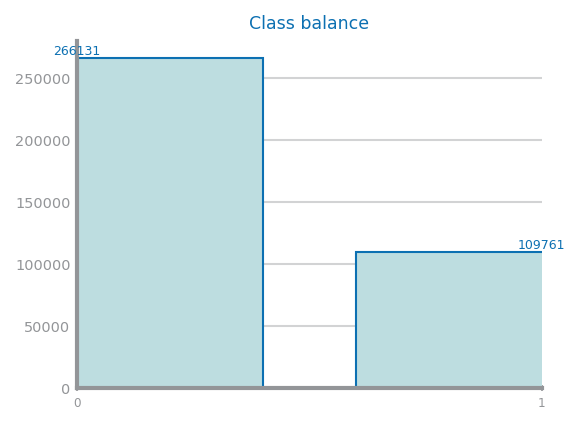

In [37]:
from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslab_functions import plot_bar_chart

file = "class_pos_covid"
target = "CovidPos"
original: DataFrame = read_csv('data/class_pos_covid/data_preparation/scaling/no_scaling.csv')

target_count: Series = original[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(target_count.index.to_list(), target_count.to_list(), title="Class balance")
show()

In [38]:
df_positives: Series = original[original[target] == positive_class]
df_negatives: Series = original[original[target] == negative_class]

### UNDERSAMPLING

In [39]:
df_neg_sample: DataFrame = DataFrame(df_negatives.sample(len(df_positives)))
df_under: DataFrame = concat([df_positives, df_neg_sample], axis=0)
df_under.to_csv(f"data/{file}/data_preparation/balancing/undersampling.csv", index=False)

print("Minority class=", positive_class, ":", len(df_positives))
print("Majority class=", negative_class, ":", len(df_neg_sample))
print("Proportion:", round(len(df_positives) / len(df_neg_sample), 2), ": 1")

Minority class= 1 : 109761
Majority class= 0 : 109761
Proportion: 1.0 : 1


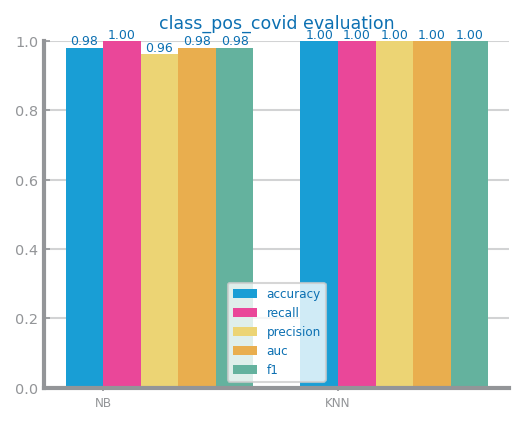

In [40]:
target = 'CovidPos'
X, y = df_under.loc[:, df_under.columns != 'CovidPos'], df_under['CovidPos']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/balancing/undersampling.png")
show()

### OVERSAMPLING

In [41]:
df_pos_sample: DataFrame = DataFrame(
    df_positives.sample(len(df_negatives), replace=True)
)
df_over: DataFrame = concat([df_pos_sample, df_negatives], axis=0)
df_over.to_csv(f"data/{file}/data_preparation/balancing/oversampling.csv", index=False)

print("Minority class=", positive_class, ":", len(df_pos_sample))
print("Majority class=", negative_class, ":", len(df_negatives))
print("Proportion:", round(len(df_pos_sample) / len(df_negatives), 2), ": 1")

Minority class= 1 : 266131
Majority class= 0 : 266131
Proportion: 1.0 : 1


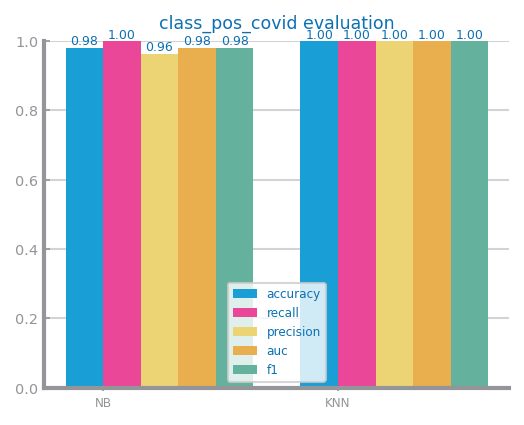

In [42]:
target = 'CovidPos'
X, y = df_over.loc[:, df_over.columns != 'CovidPos'], df_over['CovidPos']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/balancing/oversampling.png")
show()

### SMOTE (need encoding first)

In [43]:
from numpy import ndarray
from pandas import Series
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

smote: SMOTE = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)
y = original.pop(target).values
X: ndarray = original.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote: DataFrame = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
df_smote.columns = list(original.columns) + [target]
df_smote.to_csv(f"data/{file}/data_preparation/balancing/smote.csv", index=False)

smote_target_count: Series = Series(smote_y).value_counts()
print("Minority class=", positive_class, ":", smote_target_count[positive_class])
print("Majority class=", negative_class, ":", smote_target_count[negative_class])
print(
    "Proportion:",
    round(smote_target_count[positive_class] / smote_target_count[negative_class], 2),
    ": 1",
)
print(df_smote.shape)

Minority class= 1 : 266131
Majority class= 0 : 266131
Proportion: 1.0 : 1
(532262, 42)


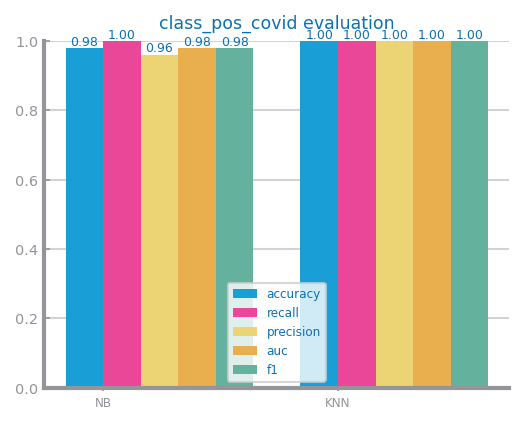

In [44]:
target = 'CovidPos'
X, y = df_smote.loc[:, df_smote.columns != 'CovidPos'], df_smote['CovidPos']
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = 0.33, random_state=1)

train = pd.concat([Xtrain, Ytrain], axis=1)
test = pd.concat([Xtest, Ytest], axis=1)

figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}/data_preparation/balancing/smote.png")
show()